# Figure 1-4 Visualisation Examples

In this notebook we show how we create our visualisation examples and how the visualisation was used. \
We rely on the visualisation tool from the Github repository: https://github.com/aohma/fuvpy

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.11922224.svg)](https://doi.org/10.5281/zenodo.11922224)


And the polar plot class from the Github repository: https://github.com/klaundal/polplot 

This is the old one but will do for now: [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.7855213.svg)](https://doi.org/10.5281/zenodo.7855213)

## Imports
First we import the functions we need

In [1]:
import pandas as pd
from polplot.polplot import Polarplot as polar
import fuvpy as fuv
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
import numpy as np
from fuvpy.utils.viewer import mlt2radians, radians2mlt, Visualise
from matplotlib import rcParams
from os.path import isfile
%matplotlib widget

## Set File Paths

In [2]:
NH_path = '/home/simon/BCSS-DAG Dropbox/Data/Conjungate_Onset_Study/Northern_Wic/'
SH_path = '/home/simon/BCSS-DAG Dropbox/Data/Conjungate_Onset_Study/Southern_Vis/'

## Load Candidate Events
This is the list of file names for each case where Polar VIS has an image when the Frey 2004 list has an onset in the northern hemisphere using IMAGE

In [3]:
Image_Times= pd.read_csv('./Candidate_Events.csv') # Loading fry substorm list


## Set Load Image kwargs

In [4]:
# Configuration for displaying images
show_image_kwargs = [{'title_y':0.9, 'in_put':'imgR'}] + [{'title_y':.82, 'in_put':'imgR'}] * 3

## Key Function Operations

In [5]:
def get_files(t):
    row = Image_Times.loc[t]
    NH_file = NH_path + row.WIC_Files
    SH_files = [fuv.add_rayleigh(fuv.read_idl(SH_path + row[f'SH{i}_Files']).isel(date=0)) for i in range(1, 4)]
    NH_file= fuv.add_rayleigh(fuv.read_idl(NH_file).isel(date=0))
    return [NH_file] + SH_files

# Update the displayed text based on the current time index
def update_df_text(vis):
    t_file= open(vis.t_file, 'r')
    t= int(t_file.read())
    t_file.close()
    columns= ['Date_SH', 'Frey_MLT', 'Frey_MLAT', 'MLT_NH', 'MLAT_NH',
              'SZA_NH', 'DZA_NH', 'MLT_SH', 'MLAT_SH', 'SZA_SH', 'DZA_SH']
    vals= vis.df.loc[t, columns]
    vis.flag= vis.df.loc[t, 'flag']
    vis.flag_color= np.array(['#b50909', 'black', '#1fa305'])[vis.flag==np.array([9.999e3, 0., 1.])][0]
    text= vis.plotted['df_text']['plot_object']
    text[0].set_text(t)
    text[0].set_color(vis.flag_color)
    vis.plotted['t_position']['plot_object'][0].set_text(f"{t} of {vis.plotted['t_position']['max_t']}")
    for t, val in zip(text[1:], vals):
        if isinstance(val, (float, int, np.float32)):
            t.set_text(str(round(val, 3)))
            t.set_color(vis.flag_color)
        else:
            t.set_text('\n'.join(str(val.to_numpy().astype('datetime64[s]')).split('T')))
            t.set_color(vis.flag_color)

## Button Functions

In [6]:
class Index(object):
    """
    Class to handle button interactions for the visualization.
    
    Attributes:
    - vis: Visualization object containing data and methods for visualization.
    """
    
    def __init__(self, vis):
        """
        Initialize Index object with a visualization object.
        
        Parameters:
        - vis: Visualization object containing data and methods for visualization.
        """
        self.vis = vis
    
    def next_(self, event):
        """
        Load and display the next image and update the displayed time.
        
        Parameters:
        - event: The event triggering the method.
        """
        t_file= open(vis.t_file, 'r')
        t= int(t_file.read())
        t_file.close()
        t+=1
        if t>len(Image_Times):
            t-= (len(Image_Times))
        if t<=0:
            t+= (len(Image_Times)-1)
        for ax, file, kwargs in zip(self.vis.axes, get_files(t), show_image_kwargs):
            self.vis.show_image(file, ax, **kwargs)
        t_file=open(vis.t_file, 'w')
        t_file.write(str(t))
        t_file.close()
        update_df_text(self.vis)
        t_file= open(self.vis.t_file, 'r')
        t= int(t_file.read())
        t_file.close()
        lat, lt= self.vis.df.loc[t, ['Frey_MLAT', 'Frey_MLT']]
        marker= self.vis.axes[0].scatter(lat, lt, marker='x', color='purple', zorder=100, s=50)
        self.vis.plotted.update({'Frey_marker': {'plot_object':[marker],
                                        'clear_on_show_image':True,
                                        'clear_on_click': False,
                                        'linked_to_colorbar':False}})
        lat, lt= self.vis.df.loc[t, ['MLAT_SH', 'MLT_SH']]
        marker= [ax.scatter(lat, lt, marker='x', color='black', zorder=100, s=50) for ax in self.vis.axes if ax.hemisphere==-1]
        self.vis.plotted.update({'SH_marker': {'plot_object':marker,
                                        'clear_on_show_image':True,
                                        'clear_on_click': True,
                                        'linked_to_colorbar':False}})
        plt.draw()
    
    def previous_(self, event):
        """
        Load and display the previous image and update the displayed time.
        
        Parameters:
        - event: The event triggering the method.
        """
        t_file= open(self.vis.t_file, 'r')
        t= int(t_file.read())
        t_file.close()
        t-=1
        if t>=len(Image_Times):
            t-= (len(Image_Times)-1)
        if t<=0:
            t+= (len(Image_Times))
        for ax, file, kwargs in zip(self.vis.axes, get_files(t), show_image_kwargs):
            self.vis.show_image(file, ax, **kwargs)
        t_file=open(vis.t_file, 'w')
        t_file.write(str(t))
        t_file.close()
        update_df_text(self.vis)
        t_file= open(self.vis.t_file, 'r')
        t= int(t_file.read())
        t_file.close()
        lat, lt= self.vis.df.loc[t, ['Frey_MLAT', 'Frey_MLT']]
        marker= self.vis.axes[0].scatter(lat, lt, marker='x', color='purple', zorder=100, s=50)
        self.vis.plotted.update({'Frey_marker': {'plot_object':[marker],
                                        'clear_on_show_image':True,
                                        'clear_on_click': False,
                                        'linked_to_colorbar':False}})
        lat, lt= self.vis.df.loc[t, ['MLAT_SH', 'MLT_SH']]
        marker= [ax.scatter(lat, lt, marker='x', color='black', zorder=100, s=50) for ax in self.vis.axes if ax.hemisphere==-1]
        self.vis.plotted.update({'SH_marker': {'plot_object':marker,
                                        'clear_on_show_image':True,
                                        'clear_on_click': True,
                                        'linked_to_colorbar':False}})
        lat, lt= self.vis.df.loc[t, ['MLAT_NH', 'MLT_NH']]
        marker= [ax.scatter(lat, lt, marker='x', color='black', zorder=100, s=50) for ax in self.vis.axes if ax.hemisphere==1]
        self.vis.plotted.update({'NH_marker': {'plot_object':marker,
                                        'clear_on_show_image':True,
                                        'clear_on_click': True,
                                        'linked_to_colorbar':False}})
        plt.draw()
    
    def bad_(self, event):
        """
        Mark the current image as bad and update its flag color.
        
        Parameters:
        - event: The event triggering the method.
        """
        self.vis.flag= 9.999e3
        self.vis.flag_color= np.array(['#b50909', 'black', '#1fa305'])[self.vis.flag==np.array([9.999e3, 0., 1.])][0]
        if 'df_text' in self.vis.plotted:
            for text in self.vis.plotted['df_text']['plot_object']:
                text.set_color('#b50909')
        vis.df.loc[t, ['flag']]= vis.flag
        plt.draw()
    
    def okay_(self, event):
        """
        Mark the current image as okay and update its flag color.
        
        Parameters:
        - event: The event triggering the method.
        """
        self.vis.flag= 0.
        self.vis.flag_color= np.array(['#b50909', 'black', '#1fa305'])[self.vis.flag==np.array([9.999e3, 0., 1.])][0]
        if 'df_text' in self.vis.plotted:
            for text in self.vis.plotted['df_text']['plot_object']:
                text.set_color('black')
        self.vis.df.loc[t, ['flag']]= vis.flag
        plt.draw()
    
    def good_(self, event):
        """
        Mark the current image as good and update its flag color.
        
        Parameters:
        - event: The event triggering the method.
        """
        self.vis.flag= 1.
        self.vis.flag_color= np.array(['#b50909', 'black', '#1fa305'])[self.vis.flag==np.array([9.999e3, 0., 1.])][0]
        if 'df_text' in self.vis.plotted:
            for text in self.vis.plotted['df_text']['plot_object']:
                text.set_color('#1fa305')
        self.vis.df.loc[t, ['flag']]= vis.flag
        plt.draw()
    
    def save_(self, event):
        """
        Save the current DataFrame to the specified save path.
        
        Parameters:
        - event: The event triggering the method.
        """
        # as long as the save path is not False will save the dataframe at the save path location
        self.vis.df.to_csv(self.vis.save_path)


## Dataframe Functions

In [7]:
# Setup the initial dataframe for visualization
def setup_dataframe(vis, onset_list, save_path):
    vis.save_path= save_path
    if isfile(save_path):
        vis.df= pd.read_csv(save_path, parse_dates=['Date_NH', 'Date_SH'], index_col=0)
    else:
        vis.df= pd.DataFrame(columns=['Date_NH', 'MLT_NH', 'MLAT_NH', 'Frey_MLT', 'Frey_MLAT', 'SZA_NH',
        'DZA_NH', 'Date_SH', 'MLT_SH', 'MLAT_SH', 'SZA_SH', 'DZA_SH', 'flag'])
        vis.df['Date_NH']= onset_list['Frey_Onset'].values
        vis.df['Frey_MLT']= onset_list['Frey_MLT'].values
        vis.df['Frey_MLAT']= onset_list['Frey_MLAT'].values
        vis.df['flag']= np.zeros(len(vis.df))
        vis.df.index= onset_list.index.values
        vis.df['Date_SH']= vis.df.Date_SH.astype('datetime64[s]')

# Setup text for the dataframe
def setup_df_text(vis, df_ax, onset_list, text_x, text_y):
    t_file= open(vis.t_file, 'r')
    t= int(t_file.read())
    t_file.close()
    columns= ['Date_SH', 'Frey_MLT', 'Frey_MLAT', 'MLT_NH', 'MLAT_NH',
              'SZA_NH', 'DZA_NH', 'MLT_SH', 'MLAT_SH', 'SZA_SH', 'DZA_SH']
    vis.flag= vis.df.loc[t, 'flag']
    vis.flag_color= np.array(['#b50909', 'black', '#1fa305'])[vis.flag==np.array([9.999e3, 0., 1.])][0]
    vals= vis.df.loc[t, columns]
    text= [df_ax.text(text_x[0], text_y[0], str(t), color=vis.flag_color), 
           df_ax.text(text_x[1], text_y[1], '\n'.join(str(vals['Date_SH'].to_numpy().astype('datetime64[s]')).split('T')), color=vis.flag_color)]
    text+= [df_ax.text(x, y, str(round(val, 3)), color= vis.flag_color) for x, y, val in zip(text_x[2:], text_y[2:], vals[columns[1:]])]
    vis.plotted.update({'df_text': {'plot_object':text,
                                    'clear_on_show_image':False,
                                    'clear_on_click': False,
                                    'linked_to_colorbar':False},
                        't_position': {'plot_object':[vis.axes[0].ax.text(3., .5, f'{t} of {len(onset_list)}')],
                                       'clear_on_show_image':False,
                                       'clear_on_click': False,
                                       'linked_to_colorbar':False,
                                       'max_t': len(onset_list)}})
    lat, lt= vis.df.loc[t, ['Frey_MLAT', 'Frey_MLT']]
    marker= vis.axes[0].scatter(lat, lt, marker='x', color='purple', zorder=100, s=50)
    vis.plotted.update({'Frey_marker': {'plot_object':[marker],
                                    'clear_on_show_image':True,
                                    'clear_on_click': False,
                                    'linked_to_colorbar':False}})
# Function to update text for dataframe
def df_text(vis, image, ind, hemisphere):
    lt, lat, sza, dza=vals= (np.nanmax(image.where(ind).lt.values), np.nanmax(image.where(ind).lat.values),
                        np.nanmax(image.where(ind).sza.values), np.nanmax(image.where(ind).dza.values))
    if hemisphere=='north':
        text= vis.plotted['df_text']['plot_object'][4:8]
    elif hemisphere=='south':
        text= vis.plotted['df_text']['plot_object'][8:]
        vis.plotted['df_text']['plot_object'][1].set_text('\n'.join(str(image.date.values.astype('datetime64[s]')).split('T')))

    else:
        raise ValueError(f"Can't figure out hemisphere from file. hemisphere: {image.hemisphere.values}")
    for t, val in zip(text, vals):
        t.set_text(str(round(val, 3)))
# Function to update the dataframe based on the selected region
def alter_df(vis, image, ind, hemisphere):
    lt, lat, sza, dza, date, flag=vals= [np.nanmax(image.where(ind).lt.values), np.nanmax(image.where(ind).lat.values),
                             np.nanmax(image.where(ind).sza.values), np.nanmax(image.where(ind).dza.values),
                             image.date.values, vis.flag]
    if hemisphere=='north':
        hem='NH'
    elif hemisphere=='south':
        hem='SH'
    else:
        raise ValueError(f"Can't figure out hemisphere from file. hemisphere: {image.hemisphere.values}")
    columns= ['MLT_'+hem, 'MLAT_'+hem, 'SZA_'+hem, 'DZA_'+hem, 'Date_'+hem, 'flag']
    t_file= open(vis.t_file, 'r')
    t= int(t_file.read())
    t_file.close()
    vis.df.loc[t, columns]= vals

## Click Interaction Function
We provide a new click interaction function in order to have more functionality over the default. \
This includes the recording of the click location into a dataframe.

In [8]:
def Click_Interaction(vis, image_axis, lt, lat, lt_axis, lat_axis, window_lat=4, window_lt=1):
    marker= [ax.scatter(lat, lt, marker='x', color='black', zorder=100, s=50) for ax in vis.axes if ax.hemisphere==image_axis.hemisphere]
    vis.plotted.update({'marker': {'plot_object':marker, 
                                        'clear_on_show_image':True,
                                        'clear_on_click': True,
                                        'linked_to_colorbar':False}})
    
    hemisphere= image_axis.image_dat.hemisphere.values
    if lt_axis and lat_axis:
        cmap=image_axis.image.get_cmap()
        lt_lims= (lt-window_lt/2, lt+window_lt/2)
        image= image_axis.image_dat.copy()
        if lt_lims[0]>=0 and lt_lims[1]<24:
            image= image.where((image.lat>=lat-window_lat/2)\
                                                           &(image.lat<=lat+window_lat/2)\
                                                           &(image.lt>=lt-window_lt/2)\
                                                           &(image.lt<=lt+window_lt/2))
        elif lt_lims[0]<0:
            image= image.where((image.lat>=lat-window_lat/2)\
                                                           &(image.lat<=lat+window_lat/2)\
                                                           &((image.lt>=24+(lt-window_lt/2))\
                                                           |(image.lt<=lt+window_lt/2)))
        elif lt_lims[1]>24:
            image= image.where((image.lat>=lat-window_lat/2)\
                                                           &(image.lat<=lat+window_lat/2)\
                                                           &((image.lt>=(lt-window_lt/2))\
                                                           |(image.lt<=(lt+window_lt/2)-24)))
        window= image_axis.plot([lat+window_lat/2]*2 + [lat-window_lat/2]*2+ [lat+window_lat/2],
                                    [lt-window_lt/2, lt+window_lt/2, lt+window_lt/2, lt-window_lt/2, lt-window_lt/2],
                                    color='black')
        vis.plotted.update({f'window_{image_axis.axis_number}': {'plot_object':window, 
                                                                 'clear_on_show_image':True,
                                                                 'clear_on_click': True,
                                                                 'linked_to_colorbar':False}})
        image= image.where(image.data!=0)
        ind= image.data== np.nanmax(image.data)
        lt_= np.nanmax(image.where(ind).lt.values)
        lat_= np.nanmax(image.where(ind).lat.values)
        df_text(vis, image, ind, hemisphere)
        alter_df(vis, image, ind, hemisphere)
        crange= image_axis.image.get_clim()
        scatter= lat_axis.scatter(image.lat.values, image.data.values, 
                                  c=image.data.values, cmap=cmap, vmin= crange[0], vmax=crange[1])
        vis.plotted.update({'scatter_lat': {'plot_object':[scatter], 
                                                                 'clear_on_show_image':True,
                                                                 'clear_on_click': True,
                                                                 'linked_to_colorbar':image_axis.cax_number+1}})
        profile= lat_axis.plot([lat]*2, [np.nanmin(image.data), np.nanmax(image.data)], color='black')
        profile.extend(lat_axis.plot([np.round(lat_, 2)]*2, [np.nanmin(image.data), np.nanmax(image.data)],
                                       color='black', linestyle='--'))
        vis.plotted.update({'profile_lat': {'plot_object':profile, 
                                            'clear_on_show_image':True,
                                            'clear_on_click':True,
                                            'linked_to_colorbar':False}})
        try:
            lat_axis.set_ylim(np.nanmin(image.data)-abs(np.nanmin(image.data))*.1,
                               np.nanmax(image.data)+ abs(np.nanmax(image.data))*.1)
        except:
            pass
        lat_axis.set_xlim((lat-window_lat/2)-abs(lat-window_lat/2)*.01, (lat+window_lat/2)+abs(lat+window_lat/2)*.01)
        radians= mlt2radians(image.lt.values)
        xlims= radians2mlt(np.array([np.nanmin(radians), np.nanmax(radians)]))
        xlims[0]= np.floor(xlims[0]*10)/10
        xlims[1]= np.ceil(xlims[1]*10)/10
        try:
            lt_axis.set_xlim(*mlt2radians(xlims))
            lt_axis.set_ylim(np.nanmin(image.data)-abs(np.nanmin(image.data))*0.1, np.nanmax(image.data)+abs(np.nanmax(image.data))*.1)
        except:
            pass
        scatter= lt_axis.scatter(radians, image.data.values, c=image.data.values, 
                        cmap=cmap, vmin=crange[0], vmax=crange[1])
        vis.plotted.update({'scatter_lt': {'plot_object':[scatter], 
                                            'clear_on_show_image':True,
                                            'clear_on_click': True,
                                            'linked_to_colorbar':image_axis.cax_number+1}})
        profile= lt_axis.plot([mlt2radians(lt)]*2, [np.nanmin(image.data), np.nanmax(image.data)], color='black')

        profile.extend(lt_axis.plot([mlt2radians(np.round(lt_, 2))]*2, [np.nanmin(image.data), np.nanmax(image.data)],
                                  color='black', linestyle='--'))
        vis.plotted.update({'profile_lt': {'plot_object':profile,
                                           'clear_on_click': True,
                                           'clear_on_show_image':True,
                                           'linked_to_colorbar':False}})
        if lt_lims[0]<0:
            labels= np.append(np.arange(24-window_lt/4, np.round(lt_lims[0]+24, 1)-window_lt/4, -window_lt/4)[::-1], np.arange(0, np.round(lt_lims[1], 1)+window_lt/4, window_lt/4))
        elif lt_lims[1]>24:
            labels= np.append(np.arange(24-window_lt/4, np.round(lt_lims[0], 1)-window_lt/4, -window_lt/4)[::-1], np.arange(0, np.round(lt_lims[1]-24, 1)+window_lt/4, window_lt/4))
        else:
            labels= np.round(np.arange(np.round(lt_lims[0], 1), np.round(lt_lims[1], 1)+window_lt/4, window_lt/4), 2)
        rads=mlt2radians(labels)
        lt_axis.set_xticks(rads, labels)


    plt.draw()

## Figure Setup

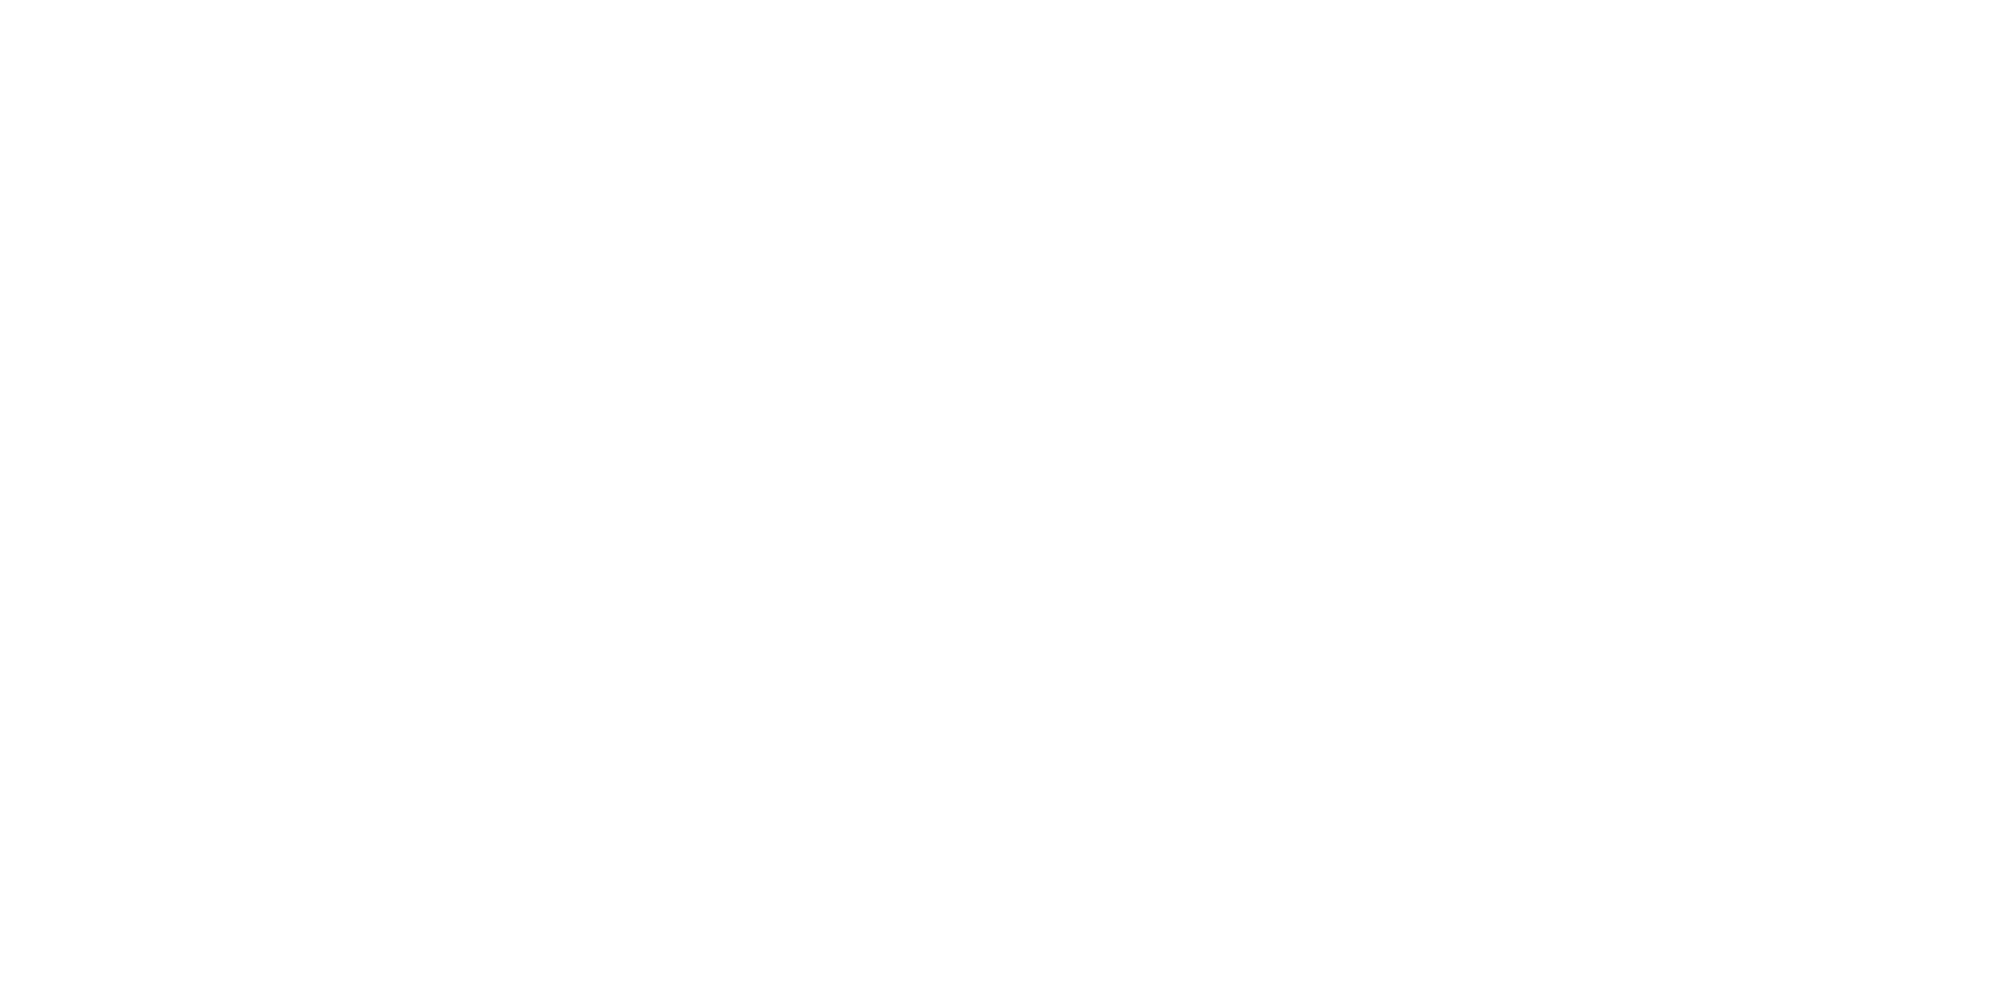

[]

In [9]:
data_frame_coords= [0.01, 0.04, 0.115,  0.205,
                    0.295, 0.379, 0.463, 
                    0.540, 0.623, 0.698,
                    0.780, 0.866] # Where the data in the dataframe is placed

fig= plt.figure(figsize=(20,10))
plt.pause(.1)
# fig.set_size_inches(15, 10) # Had to do it like this because for me it wouldn't 
#                               # always make the figure the correct size
fig.set_size_inches(np.array([18.7, 11.05]))

""" Further Setting up the Figure """
gs= fig.add_gridspec(6, 7, width_ratios=[.15,.15,.7, 1, .7, .15, .15], height_ratios=[1, 1, 0.3, 0.1, .1, .1], 
                     wspace=0, hspace=0)

# First Row
NHpax= polar(fig.add_subplot(gs[0,3]), sector='night', lt_label='mlt', lat_label='mlat')
NHpax.axis_number=0
# NHpax.hemisphere='NH'
MLTax= fig.add_subplot(gs[0, :3])
MLATax= fig.add_subplot(gs[0, 4:])
NHpax.ax.text(-0.4, 0.5, 'Northern Hemisphere')
fig.text(.15, .85, 'A', va='center', ha='center', size=40, zorder=20000)
fig.text(.515, .8, 'B', va='center', ha='center', size=40, zorder=20000)
fig.text(.7, .85, 'C', va='center', ha='center', size=40, zorder=20000)

# Second Row
SHpax1= polar(fig.add_subplot(gs[1,:3]), sector='night', lt_label='mlt', lat_label='mlat')
SHpax1.axis_number=1
# SHpax1.hemisphere='SH'
SHpax2= polar(fig.add_subplot(gs[1,3]), sector='night', lt_label='mlt', lat_label='mlat')
SHpax2.axis_number=2
# SHpax2.hemisphere='SH'
SHpax2.ax.text(-0.35, 0.1, 'Southern Hemisphere')
SHpax3= polar(fig.add_subplot(gs[1,4:]), sector='night', lt_label='mlt', lat_label='mlat')
SHpax3.axis_number=3
# SHpax3.hemisphere='SH'
fig.text(.255, .5, 'D', va='center', ha='center', size=40, zorder=20000)
fig.text(.515, .5, 'E', va='center', ha='center', size=40, zorder=20000)
fig.text(.773, .5, 'F', va='center', ha='center', size=40, zorder=20000)


# Third Row
df_ax= fig.add_subplot(gs[-4, 2:-2])
bad_ax= fig.add_subplot(gs[-4, 0])
good_ax= fig.add_subplot(gs[-4, 1])
save_ax=fig.add_subplot(gs[-4, -1])
okay_ax=fig.add_subplot(gs[-4, -2])
bbad=Button(bad_ax, 'bad\nflag', hovercolor='#db0909', color='#b50909')
bgood= Button(good_ax, 'good\nflag', hovercolor='#2ce014', color='#1fa305')
bokay= Button(okay_ax, 'okay\nflag')
bsave= Button(save_ax, 'save')

# Fourth Row
caxNH= fig.add_subplot(gs[-2, 2:-2])
caxNH
caxSH= fig.add_subplot(gs[-1, 2:-2])
caxNH.xaxis.tick_top()
caxNH.xaxis.set_label_position('top')
# SHcax= NHcax.twinx()
previous_ax= fig.add_subplot(gs[-3:, :2], zorder=-1)
next_ax= fig.add_subplot(gs[-3:, -2:], zorder=-1)
bprevious=Button(previous_ax, "Previous")
bnext=Button(next_ax,"Forward")

MLTax.set_title('MLT Pixel Profile')
MLTax.set_frame_on(False)
MLTax.set_xlabel('MLT [Hr]')
MLTax.set_ylabel('Pixel Intensity [kR]')

MLATax.set_title('MLat Pixel Profile')
MLATax.set_frame_on(False)
MLATax.set_xlabel(r'MLat [$^\circ$]')
MLATax.set_ylabel('Pixel Intensity [kR]', rotation=-90, labelpad=10)
MLATax.yaxis.set_ticks_position('right')
MLATax.yaxis.set_label_position("right")
MLATax.set_xlim(50, 90)
df_ax.set_xlim(0, 1)
df_ax.set_ylim(0, 1)
size=10
# Data frame titles
text=[df_ax.text(0.002, .8, 'Index', size=size), df_ax.text(0.055, .8, 'Time', size=size),
      df_ax.text(0.112, .8, 'Frey MLT', size=size, color='m'), df_ax.text(0.19, .8, 'Frey MLAT', size=size, color='m'),
      df_ax.text(0.29, .8, 'MLT NH', size=size), df_ax.text(0.37, .8, 'MLAT NH', size=size),
      df_ax.text(0.46, .8, 'SZA NH', size=size), df_ax.text(0.535, .8, 'DZA NH', size=size),
      df_ax.text(0.615, .8, 'MLT SH', size=size), df_ax.text(0.69, .8, 'MLAT SH', size=size),
      df_ax.text(0.783, .8, 'SZA SH', size=size), df_ax.text(.865, .8, 'DZA SH', size=size), 
      df_ax.text(0.95, .8, 'Key', size=size)]
# Creating data frame cells
line_kwargs={'color':'black', 'lw':.5}
lines= [df_ax.plot([0.035]*2, [0, 1], **line_kwargs), df_ax.plot([0.108]*2, [0, 1], **line_kwargs),
        df_ax.plot([0.185]*2, [0, 1], **line_kwargs), df_ax.plot([0.285]*2, [0, 1], **line_kwargs),
        df_ax.plot([0.365]*2, [0, 1], **line_kwargs), df_ax.plot([0.455]*2, [0, 1], **line_kwargs),
        df_ax.plot([0.528]*2, [0, 1], **line_kwargs), df_ax.plot([0.608]*2, [0, 1], **line_kwargs),
        df_ax.plot([0.685]*2, [0, 1], **line_kwargs), df_ax.plot([0.774]*2, [0, 1], **line_kwargs),
        df_ax.plot([0.858]*2, [0, 1], **line_kwargs), df_ax.plot([0.935]*2, [0, 1], **line_kwargs)]
key_size= 8
df_ax.plot([0, 1], [0.75]*2, color='black', lw=0.85)
s=20
df_ax.scatter(0.944, 0.6, marker= 'x', color='m', s=s)
df_ax.text(0.953, 0.55, s='Frey', color='m', size=key_size)
df_ax.scatter(0.944, 0.4, marker= 'x', color='black', s=s)
df_ax.text(0.953, 0.35, s='User', color='black', size=key_size)
df_ax.text(0.943, 0.22, s='Adjustment', size=2.6*key_size/4, va='top')
df_ax.text(0.945, 0.16, s='Window', size=2.6*key_size/4, va='top')
width= 0.057
height= 0.25
x= 0.967
y= 0.16
# df_ax.plot([x+width/2, x+width/2.5] + [x-width/2.5, x-width/2]+ [x+width/2], [y-height/2, y+height/2, 
#                                                y+height/2, y-height/2, 
#                                                y-height/2], color='m', lw=1)
df_ax.plot([x+width/2, x+width/2.5] + [x-width/2.5, x-width/2]+ [x+width/2], [y-height/2, y+height/2, 
                                               y+height/2, y-height/2, 
                                               y-height/2], color='black', lw=.5)


df_ax.set_xlim(0, 1)

# Remove unwanted components of dataframe axis
df_ax.set_xticklabels([])
df_ax.set_xticks([])
df_ax.set_yticklabels([])
df_ax.set_yticks([])

## Set adjustement box size
This is automated correction box size that will select the highest pixel intensity in the region of the click

In [10]:
mlat_size= 4 # goes from clicked mlat -2 to clicked mlat +2
mlt_size= 1 # goes from clicked mlt -0.5 to clicked mlt +0.5

## Intilialise Visualisation

In [11]:
vis= Visualise(fig, [NHpax, SHpax1, SHpax2, SHpax3],
               [caxNH, caxSH], cax_association=[0, 1, 1, 1],
               lt_axis=MLTax, lat_axis=MLATax, hemispheres= [1, -1, -1, -1], click_function= Click_Interaction)

## Dataframe and Button Initialisation

In [12]:
setup_dataframe(vis, Image_Times, save_path='./test.csv')


# Buttons setup
callback= Index(vis)
bprevious.on_clicked(callback.previous_)
bnext.on_clicked(callback.next_)
bbad.on_clicked(callback.bad_)
bgood.on_clicked(callback.good_)
bokay.on_clicked(callback.okay_)
bsave.on_clicked(callback.save_)

0

## Initialise

In [13]:
t = 95 # method example

f = open('t.txt', 'w')
f.write(str(t))
f.close()
vis.t_file = 't.txt'
vis.text_xcoords = data_frame_coords.copy()
vis.text_xcoords[1] -= 0.003
vis.text_ycoords = [.4] * len(vis.text_xcoords)
vis.text_ycoords[1] = .4
setup_df_text(vis, df_ax, Image_Times, vis.text_xcoords, vis.text_ycoords)

# Load and display initial images
files= get_files(t)
for ax, file, kwargs in zip([NHpax, SHpax1, SHpax2, SHpax3], files, show_image_kwargs):
    _, cbar = vis.show_image(file, ax, cbar_orientation='horizontal', cmap='jet', **kwargs)
    if ax.hemisphere==1:
        cbar.set_label('NH [kR]')
    elif ax.hemisphere==-1:
        cbar.set_label('SH [kR]')